In [10]:
# Standard libraries
import sys
# Add your custom path
gems_tco_path = "/Users/joonwonlee/Documents/GEMS_TCO-1/src"
sys.path.append(gems_tco_path)
import os
import logging
import argparse # Argument parsing

# Data manipulation and analysis
import pandas as pd
import numpy as np
import pickle
import torch
import torch.optim as optim
import copy                    # clone tensor
import time

# Custom imports


from GEMS_TCO import kernels_reparam_space_time_gpu as kernels_reparam_space_time
from GEMS_TCO import orderings as _orderings 
from GEMS_TCO import alg_optimization, alg_opt_Encoder

from typing import Optional, List, Tuple
from pathlib import Path
import typer
import json
from json import JSONEncoder
from GEMS_TCO import configuration as config
from GEMS_TCO.data_loader import load_data2, exact_location_filter
from GEMS_TCO import debiased_whittle
from torch.nn import Parameter

In [11]:
space: List[str] = ['1', '1']
lat_lon_resolution = [int(s) for s in space]
mm_cond_number: int = 8
years = ['2024']
month_range = [7] 

output_path = input_path = Path(config.mac_estimates_day_path)
data_load_instance = load_data2(config.mac_data_load_path)

#lat_range_input = [1, 3]
#lon_range_input = [125.0, 129.0]

lat_range_input=[0,5]      
lon_range_input=[123, 133.0] 

lat_range_input=[-5,7]      
lon_range_input=[120, 135.0] 


df_map, ord_mm, nns_map = data_load_instance.load_maxmin_ordered_data_bymonthyear(
lat_lon_resolution=lat_lon_resolution, 
mm_cond_number=mm_cond_number,
years_=years, 
months_=month_range,

lat_range=lat_range_input,   
lon_range=lon_range_input

)

Subsetting data to lat: [-5, 7], lon: [120, 135.0]


In [14]:
daily_aggregated_tensors_dw = [] 
daily_hourly_maps_dw = []      

daily_aggregated_tensors_vecc = [] 
daily_hourly_maps_vecc = []   


for day_index in range(31):
    hour_start_index = day_index * 8
    
    hour_end_index = (day_index + 1) * 8
    #hour_end_index = day_index*8 + 1
    hour_indices = [hour_start_index, hour_end_index]

    day_hourly_map, day_aggregated_tensor = data_load_instance.load_working_data(
    df_map, 
    hour_indices, 
    ord_mm= None,  # or just omit it
    dtype=torch.float64, # or just omit it 
    keep_ori=True  #keep_exact_loc
    )

    daily_aggregated_tensors_dw.append( day_aggregated_tensor )
    daily_hourly_maps_dw.append( day_hourly_map )



In [18]:
daily_hourly_maps_dw[2]['2024_07_y24m07day03_hm07:49']

tensor([[  6.9965, 131.7240, 267.9705,  76.0000],
        [  6.9965, 131.7240, 267.9705,  76.0000],
        [  6.9965, 131.7240, 267.9705,  76.0000],
        ...,
        [ -4.9592, 120.1127, 260.0174,  76.0000],
        [ -4.9593, 120.0485, 259.1019,  76.0000],
        [ -4.9595, 119.9858, 258.1088,  76.0000]], dtype=torch.float64)

In [ ]:
day = 1 

hour = 1
keys = list(daily_hourly_maps_dw[day].keys())
# 1. Get the specific tensor data
daily_hourly_maps_dw[day][keys[hour]][:200]



tensor([[  6.9846, 134.9803, 265.6344,  46.0000],
        [  6.9845, 134.9175, 263.7244,  46.0000],
        [  6.9845, 134.8537, 264.7156,  46.0000],
        [  6.9847, 134.7908, 262.8594,  46.0000],
        [  6.9850, 134.7267, 262.2709,  46.0000],
        [  6.9851, 134.6634, 262.8673,  46.0000],
        [  6.9850, 134.6001, 262.8659,  46.0000],
        [  6.9848, 134.5367, 263.5830,  46.0000],
        [  6.9848, 134.4734, 263.9791,  46.0000],
        [  6.9846, 134.4102, 262.7868,  46.0000],
        [  6.9845, 134.3470, 261.3652,  46.0000],
        [  6.9845, 134.2834, 261.7023,  46.0000],
        [  6.9846, 134.2205, 261.8761,  46.0000],
        [  6.9845, 134.1567, 261.5065,  46.0000],
        [  6.9845, 134.0938, 261.9810,  46.0000],
        [  6.9845, 134.0303, 262.1270,  46.0000],
        [  6.9845, 133.9671, 262.5797,  46.0000],
        [  6.9845, 133.9038, 261.2000,  46.0000],
        [  6.9846, 133.8408, 259.9795,  46.0000],
        [  6.9846, 133.7774, 261.7138,  46.0000],


# 2,7 blank on lat:3,5  
# 1,1 blank on lon:130,132
# 10,5 blank on lon:128,130 serious
# 23,3 blank on everywhere

i should choose longitude 120.5 to 130.5 

/var/folders/9p/53hd4c7d2fl193h4jwp194wc0000gn/T/ipykernel_5547/2346099903.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


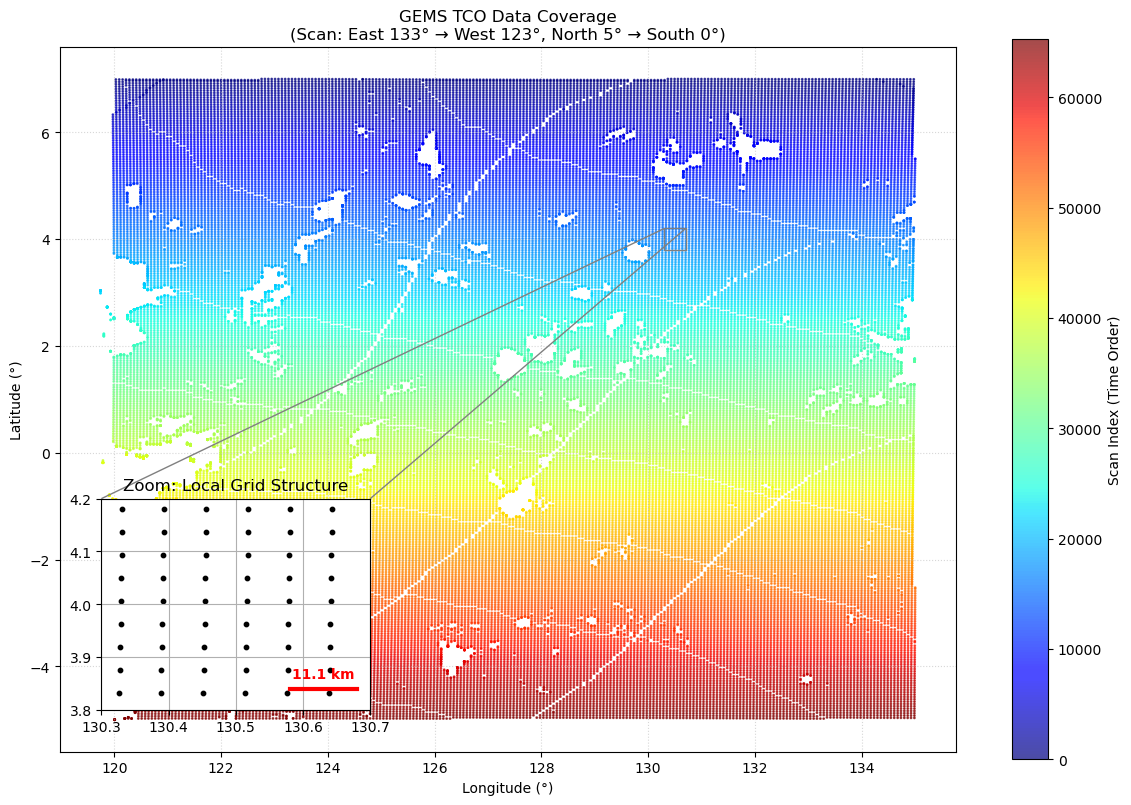

In [42]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

day = 2
hour = 3
keys = list(daily_hourly_maps_dw[day].keys())
# 1. Get the specific tensor data
data_tensor = daily_hourly_maps_dw[day][keys[hour]]

# Convert to numpy for plotting (assuming CPU tensor)
# If on GPU, use .cpu().numpy()
data = data_tensor.numpy()

# 2. Extract Coordinates
# Based on your previous tensor snippet: Column 0 is Lat, Column 1 is Lon
lats = data[:, 0]
lons = data[:, 1]

# 3. Setup the Main Plot
fig, ax = plt.subplots(figsize=(12, 8))

# Scatter plot: Color by index to show the scan path (East -> West, North -> South)
# s=1 makes the points small enough to see the density without overlapping too much
sc = ax.scatter(lons, lats, c=np.arange(len(lats)), cmap='jet', s=1, alpha=0.7)
cbar = plt.colorbar(sc, label='Scan Index (Time Order)')

ax.set_title('GEMS TCO Data Coverage\n(Scan: East 133° → West 123°, North 5° → South 0°)')
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')
ax.grid(True, linestyle=':', alpha=0.5)

# Ensure aspect ratio is equal so 1 degree Lat looks the same as 1 degree Lon
ax.set_aspect('equal')

# 4. Create Zoomed Inset to Exemplify Scale/Grid Structure
# Location: Lower Left of the plot
axins = inset_axes(ax, width="30%", height="30%", loc='lower left', borderpad=3)

# Filter data for the center of the region to zoom in
center_lat = 4.
center_lon = 130.5
zoom_radius = 0.2  # +/- 0.2 degrees (total window ~0.4 degrees)

mask = (lats > center_lat - zoom_radius) & (lats < center_lat + zoom_radius) & \
       (lons > center_lon - zoom_radius) & (lons < center_lon + zoom_radius)

subset_lats = lats[mask]
subset_lons = lons[mask]

# Plot the subset in the inset with larger markers
axins.scatter(subset_lons, subset_lats, c='k', s=10)

# Set limits for the inset
axins.set_xlim(center_lon - zoom_radius, center_lon + zoom_radius)
axins.set_ylim(center_lat - zoom_radius, center_lat + zoom_radius)
axins.set_title("Zoom: Local Grid Structure")
axins.grid(True)

# 5. Add a Physical Scale Bar to the Inset
# At Equator/Low Latitudes, 1° Lat ≈ 110.57 km, 1° Lon ≈ 111.32 km * cos(lat)
# For Lat ~2.5°, cos(2.5°) is approx 1, so ~111km per degree is a safe estimate.
km_per_deg = 111.0
scale_bar_deg = 0.1  # We want to show a bar representing 0.1 degrees
scale_bar_km = scale_bar_deg * km_per_deg

# Draw the scale line in the inset (bottom right corner of inset)
bar_x = center_lon + zoom_radius * 0.4
bar_y = center_lat - zoom_radius * 0.8

axins.plot([bar_x, bar_x + scale_bar_deg], [bar_y, bar_y], 'r-', linewidth=3)
axins.text(bar_x + scale_bar_deg/2, bar_y + 0.02, f'{scale_bar_km:.1f} km', 
           color='red', ha='center', fontweight='bold', fontsize=10)

# Connect inset to main plot
mark_inset(ax, axins, loc1=2, loc2=1, fc="none", ec="0.5")

plt.tight_layout()
plt.show()

First two latitude rows.

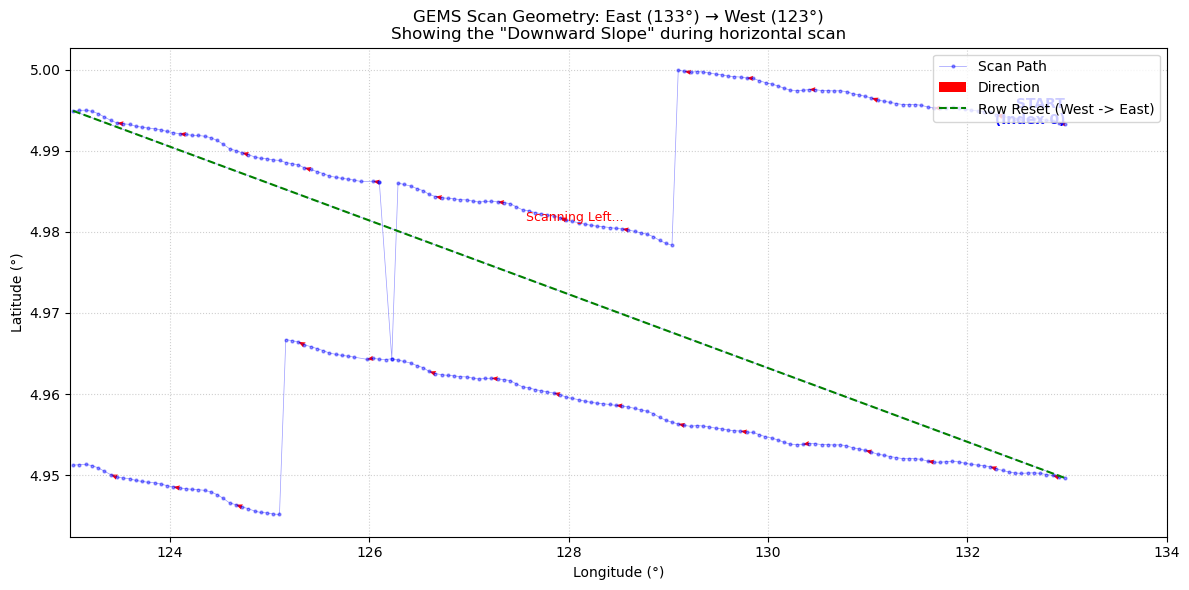

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Load Data ---
day = 1
keys = list(daily_hourly_maps_dw[day].keys())
data_tensor = daily_hourly_maps_dw[day][keys[1]]
data = data_tensor.numpy() 

lats = data[:, 0]
lons = data[:, 1]

# --- 2. Isolate First 2 Rows to "Amplify" the view ---
# Find where the longitude jumps back to the East (Start of new row)
# The diff will be positive and large (~10 degrees) when resetting 123 -> 133
lon_diff = np.diff(lons)
row_starts = np.where(lon_diff > 5.0)[0] + 1 
row_starts = np.insert(row_starts, 0, 0)

# Slice only the first 2 full rows (approx 200-400 points) to keep it clean
if len(row_starts) > 2:
    slice_end = row_starts[2]
else:
    slice_end = len(lats)

sub_lats = lats[:slice_end]
sub_lons = lons[:slice_end]

# --- 3. Plotting ---
fig, ax = plt.subplots(figsize=(12, 6))

# A. Plot the connected path (The Trace)
ax.plot(sub_lons, sub_lats, 'b.-', markersize=4, linewidth=0.5, alpha=0.4, label='Scan Path')

# B. Add Arrows to show direction (East -> West)
# We plot an arrow every 10 points to avoid clutter
step = 10
# u, v are the components of the arrow vectors
u = np.diff(sub_lons, append=sub_lons[-1])[::step]
v = np.diff(sub_lats, append=sub_lats[-1])[::step]
q_lons = sub_lons[::step]
q_lats = sub_lats[::step]

ax.quiver(q_lons, q_lats, u, v, angles='xy', scale_units='xy', scale=1, 
          color='red', width=0.004, headwidth=4, label='Direction')

# C. Highlight the "Row Jump" (The Reset)
# This connects the end of Row 1 (West) to the start of Row 2 (East)
# We make this a dashed green line to show it's a "reset" motion, not a scan
if len(row_starts) > 1:
    jump_idx = row_starts[1] - 1
    ax.plot(sub_lons[jump_idx:jump_idx+2], sub_lats[jump_idx:jump_idx+2], 
            'g--', linewidth=1.5, label='Row Reset (West -> East)')

# D. Annotate Start and End of the first row to be clear
ax.text(sub_lons[0], sub_lats[0], ' START\n (Index 0)', color='blue', fontweight='bold', ha='right')
mid_idx = row_starts[1] // 2
ax.text(sub_lons[mid_idx], sub_lats[mid_idx], ' Scanning Left...', color='red', fontsize=9, ha='center')

# --- 4. Crucial Formatting for the "Slope" ---
ax.set_title('GEMS Scan Geometry: East (133°) → West (123°)\nShowing the "Downward Slope" during horizontal scan')
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')

# FORCE Standard Map Orientation: 123 Left, 133 Right
ax.set_xlim(123, 134) 

# DO NOT use "equal" aspect. 
# We explicitly stretch the Y-axis so a 0.05 degree drop looks huge.
# If your lats are around 4.0 to 5.0, this will auto-scale to show the slant.

ax.grid(True, linestyle=':', alpha=0.6)
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

Row 10 and 11

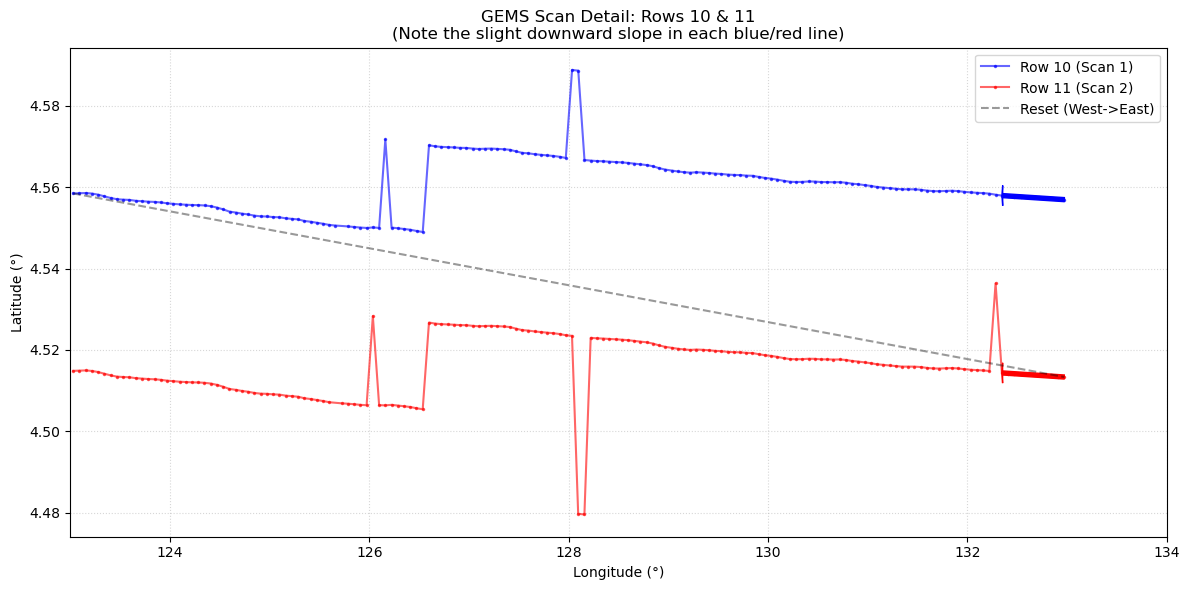

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Load Data ---
day = 1
keys = list(daily_hourly_maps_dw[day].keys())
data_tensor = daily_hourly_maps_dw[day][keys[1]]
data = data_tensor.numpy() 

lats = data[:, 0]
lons = data[:, 1]

# --- 2. Identify Rows ---
# Find indices where Longitude jumps positive (resetting from West back to East)
lon_diff = np.diff(lons)
row_starts = np.where(lon_diff > 5.0)[0] + 1 
row_starts = np.insert(row_starts, 0, 0) # Include the very first start

# --- 3. Select Two "Middle" Consecutive Rows ---
# Let's pick Row 10 and Row 11 (arbitrary middle rows) to avoid edge cases
# If the data is small, we fallback to Row 0 and 1
start_row_idx = 10 if len(row_starts) > 12 else 0

idx_start_1 = row_starts[start_row_idx]
idx_end_1   = row_starts[start_row_idx + 1]
idx_end_2   = row_starts[start_row_idx + 2]

# Extract Data for Row A and Row B
row_a_lons = lons[idx_start_1:idx_end_1]
row_a_lats = lats[idx_start_1:idx_end_1]

row_b_lons = lons[idx_end_1:idx_end_2]
row_b_lats = lats[idx_end_1:idx_end_2]

# --- 4. Plotting ---
fig, ax = plt.subplots(figsize=(12, 6))

# Plot Row A (The Upper Row)
ax.plot(row_a_lons, row_a_lats, 'b.-', label=f'Row {start_row_idx} (Scan 1)', markersize=3, alpha=0.6)
# Add arrow for Row A
ax.arrow(row_a_lons[0], row_a_lats[0], row_a_lons[10]-row_a_lons[0], row_a_lats[10]-row_a_lats[0], 
         head_width=0.005, color='blue', length_includes_head=True)

# Plot Row B (The Lower Row)
ax.plot(row_b_lons, row_b_lats, 'r.-', label=f'Row {start_row_idx+1} (Scan 2)', markersize=3, alpha=0.6)
# Add arrow for Row B
ax.arrow(row_b_lons[0], row_b_lats[0], row_b_lons[10]-row_b_lons[0], row_b_lats[10]-row_b_lats[0], 
         head_width=0.005, color='red', length_includes_head=True)

# Visualize the "Jump" (Reset)
# Connect End of Row A -> Start of Row B
ax.plot([row_a_lons[-1], row_b_lons[0]], [row_a_lats[-1], row_b_lats[0]], 
        'k--', alpha=0.4, label='Reset (West->East)')

# --- 5. Formatting ---
ax.set_title(f'GEMS Scan Detail: Rows {start_row_idx} & {start_row_idx+1}\n(Note the slight downward slope in each blue/red line)')
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')

# Standard Map View: 123 Left, 133 Right
ax.set_xlim(123, 134) 

# UNLOCKED Aspect Ratio
# This allows the plot to stretch vertically, making the slope visible.
ax.grid(True, linestyle=':', alpha=0.5)
ax.legend()

plt.tight_layout()
plt.show()